In [2]:
!pip install -q torch torchvision torchaudio scikit-learn matplotlib

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Set your dataset path
train_dir = '/content/drive/MyDrive/DLMini/Training'
test_dir = '/content/drive/MyDrive/DLMini/Testing'


Mounted at /content/drive


In [4]:
image_size = 224

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
from torchvision.models import vgg16, VGG16_Weights

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the VGG16 model with pre-trained weights
weights = VGG16_Weights.DEFAULT
vgg16_model = vgg16(weights=weights)

# Freeze feature extractor layers
for param in vgg16_model.features.parameters():
    param.requires_grad = False

# Replace classifier head
vgg16_model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names))
)

# Send model to GPU or CPU
vgg16_model = vgg16_model.to(device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 132MB/s] 


In [7]:
learning_rate = 0.0001
num_epochs = 10

# Use the correct model variable
optimizer = optim.Adam(vgg16_model.classifier.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [8]:
def train_model_with_val(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")

    return train_loss, train_acc, val_loss, val_acc


In [9]:
import matplotlib.pyplot as plt

def plot_training_results(train_loss, train_acc, val_loss, val_acc):
    epochs = range(len(train_loss))

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'o-', label='Train Loss')
    plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'o-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Epoch 1/10 - Validation: 100%|██████████| 41/41 [05:55<00:00,  8.66s/it]


Epoch 1/10 | Train Loss: 0.4700, Acc: 81.83% | Val Loss: 0.3127, Acc: 87.19%


Epoch 2/10 - Validation: 100%|██████████| 41/41 [00:14<00:00,  2.87it/s]


Epoch 2/10 | Train Loss: 0.2458, Acc: 90.90% | Val Loss: 0.2421, Acc: 90.85%


Epoch 3/10 - Validation: 100%|██████████| 41/41 [00:13<00:00,  2.93it/s]


Epoch 3/10 | Train Loss: 0.1869, Acc: 93.10% | Val Loss: 0.2134, Acc: 91.00%


Epoch 4/10 - Validation: 100%|██████████| 41/41 [00:13<00:00,  2.95it/s]


Epoch 4/10 | Train Loss: 0.1552, Acc: 94.57% | Val Loss: 0.1789, Acc: 93.36%


Epoch 5/10 - Validation: 100%|██████████| 41/41 [00:14<00:00,  2.86it/s]


Epoch 5/10 | Train Loss: 0.1295, Acc: 95.29% | Val Loss: 0.1267, Acc: 95.35%


Epoch 6/10 - Validation: 100%|██████████| 41/41 [00:13<00:00,  2.93it/s]


Epoch 6/10 | Train Loss: 0.1035, Acc: 96.25% | Val Loss: 0.1699, Acc: 93.82%


Epoch 7/10 - Validation: 100%|██████████| 41/41 [00:14<00:00,  2.93it/s]


Epoch 7/10 | Train Loss: 0.1066, Acc: 96.53% | Val Loss: 0.1193, Acc: 95.50%


Epoch 8/10 - Validation: 100%|██████████| 41/41 [00:13<00:00,  2.94it/s]


Epoch 8/10 | Train Loss: 0.0924, Acc: 96.66% | Val Loss: 0.1306, Acc: 94.89%


Epoch 9/10 - Validation: 100%|██████████| 41/41 [00:14<00:00,  2.87it/s]


Epoch 9/10 | Train Loss: 0.0748, Acc: 97.34% | Val Loss: 0.1218, Acc: 95.19%


Epoch 10/10 - Validation: 100%|██████████| 41/41 [00:14<00:00,  2.83it/s]


Epoch 10/10 | Train Loss: 0.0786, Acc: 96.78% | Val Loss: 0.1214, Acc: 95.58%


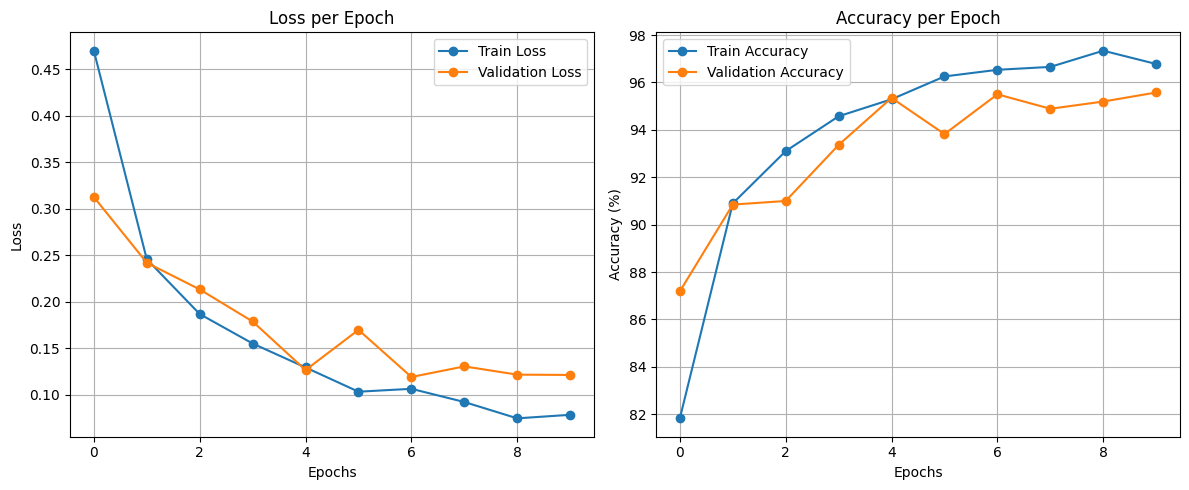

In [10]:
train_loss, train_acc, val_loss, val_acc = train_model_with_val(
    vgg16_model, train_loader, test_loader, criterion, optimizer, num_epochs
)

plot_training_results(train_loss, train_acc, val_loss, val_acc)


In [11]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


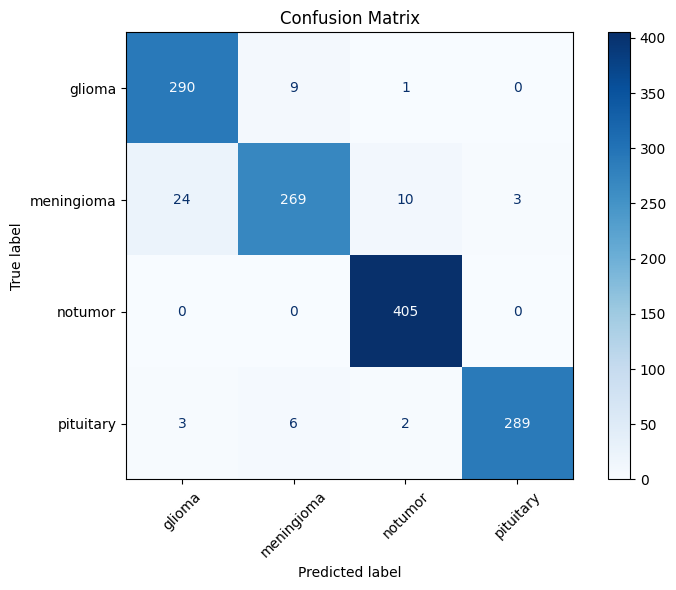

In [12]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
plot_confusion_matrix(vgg16_model, test_loader, class_names)


In [13]:
import torch
from sklearn.metrics import f1_score

def calculate_f1_score(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute weighted F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"F1 Score (Weighted): {f1:.4f}")
    return f1


In [14]:
f1 = calculate_f1_score(vgg16_model, test_loader)


F1 Score (Weighted): 0.9554
